In [2]:
import tensorflow as tf

# Configure memory growth for the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        # Set memory growth before runtime initialization
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(f"Using GPU: {physical_devices[0]}")
    except RuntimeError as e:
        # Memory growth must be set before runtime initialization
        print(f"RuntimeError: {e}")
else:
    print("No GPU found. Training will use CPU.")

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import tensorflow as tf
from tensorflow.keras.models import Model ,load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
dataset_path = './Multi Cancer/Cervical Cancer'

Total cervix_dyk images: 5000
Total cervix_koc images: 5000
Total cervix_mep images: 5000
Total cervix_pab images: 5000
Total cervix_sfi images: 5000


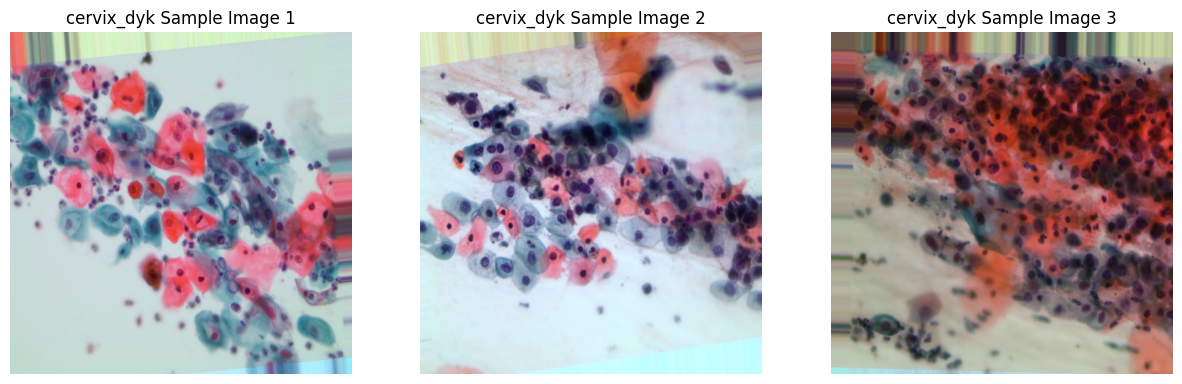

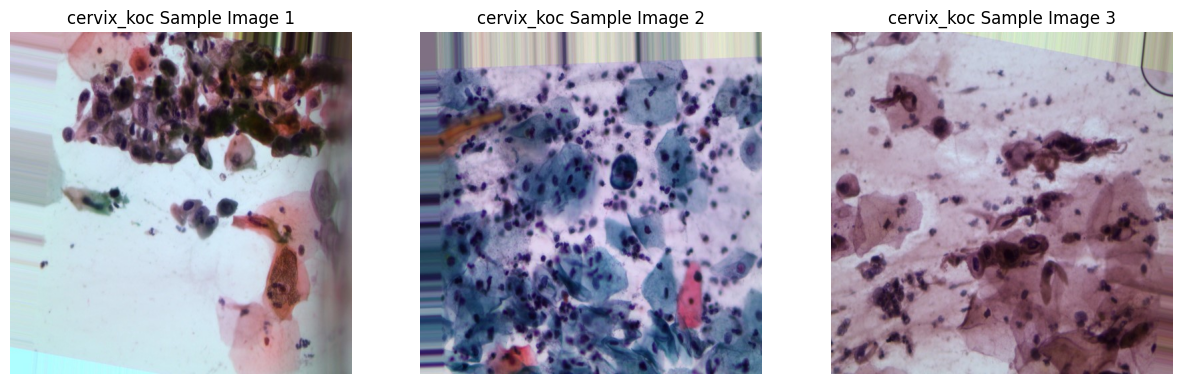

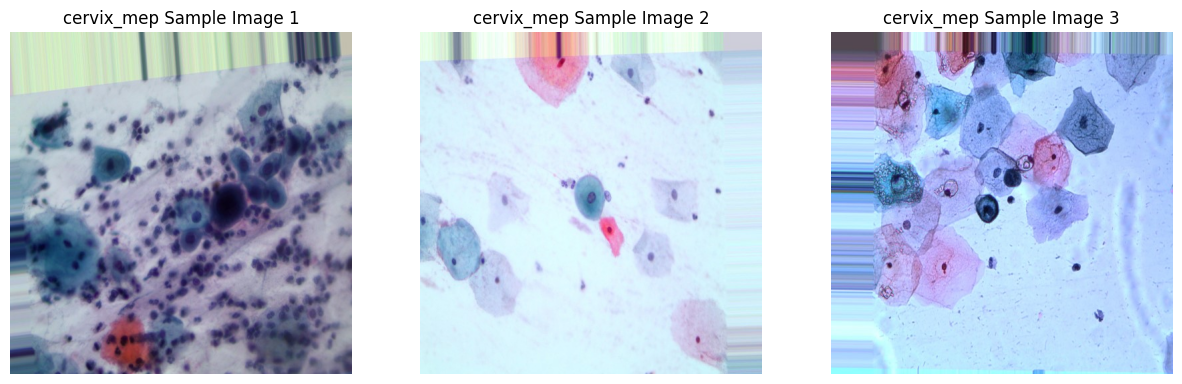

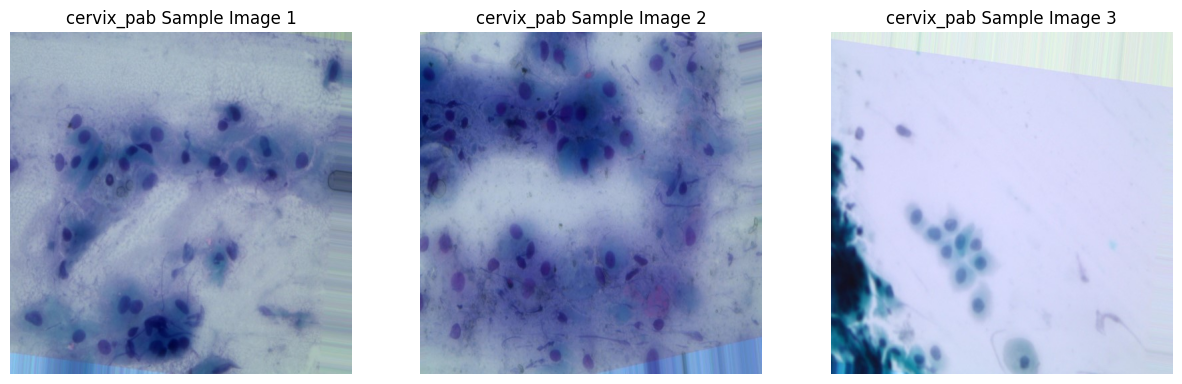

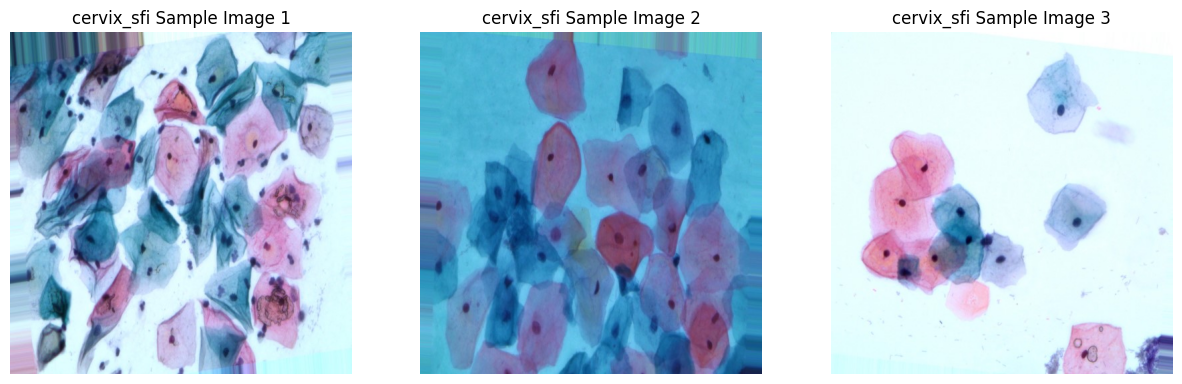

In [5]:
cervix_categories = ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']

image_counts = {}

for category in cervix_categories:
    category_path = os.path.join(dataset_path, category)
    image_counts[category] = len(os.listdir(category_path))

for category, count in image_counts.items():
    print(f"Total {category} images: {count}")

def display_samples(image_paths, title, num_samples=3):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img_path = image_paths[i]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"{title} {i + 1}")
        plt.axis('off')
    plt.show()

for category in cervix_categories:
    category_path = os.path.join(dataset_path, category)
    images_list = os.listdir(category_path)
    display_samples([os.path.join(category_path, img) for img in images_list[:3]], f"{category} Sample Image")

In [6]:
data_dir='./Multi Cancer'
target_folder='Cervical Cancer'
filepath=[]
labels=[]
all_folder_path = os.path.join(data_dir, target_folder)

if os.path.isdir(all_folder_path):
    filelist = os.listdir(all_folder_path)
    for f in filelist:
        fpath = os.path.join(all_folder_path, f)
        fipath=os.listdir(fpath)
        for image in fipath:
            path = os.path.join(fpath, image)
            filepath.append(path)
            labels.append(f)  

f_series = pd.Series(filepath, name='filepath')
l_series = pd.Series(labels, name='labels')
df = pd.concat([f_series, l_series], axis=1)
print(df.head())

print(df.dtypes)

print(df.isnull().sum())

print(df.describe())

                                            filepath      labels
0  ./Multi Cancer\Cervical Cancer\cervix_dyk\cerv...  cervix_dyk
1  ./Multi Cancer\Cervical Cancer\cervix_dyk\cerv...  cervix_dyk
2  ./Multi Cancer\Cervical Cancer\cervix_dyk\cerv...  cervix_dyk
3  ./Multi Cancer\Cervical Cancer\cervix_dyk\cerv...  cervix_dyk
4  ./Multi Cancer\Cervical Cancer\cervix_dyk\cerv...  cervix_dyk
filepath    object
labels      object
dtype: object
filepath    0
labels      0
dtype: int64
                                                 filepath      labels
count                                               25000       25000
unique                                              25000           5
top     ./Multi Cancer\Cervical Cancer\cervix_dyk\cerv...  cervix_dyk
freq                                                    1        5000


In [7]:
df

filepath      labels
0      ./Multi Cancer\Cervical Cancer\cervix_dyk\cerv...  cervix_dyk
1      ./Multi Cancer\Cervical Cancer\cervix_dyk\cerv...  cervix_dyk
2      ./Multi Cancer\Cervical Cancer\cervix_dyk\cerv...  cervix_dyk
3      ./Multi Cancer\Cervical Cancer\cervix_dyk\cerv...  cervix_dyk
4      ./Multi Cancer\Cervical Cancer\cervix_dyk\cerv...  cervix_dyk
...                                                  ...         ...
24995  ./Multi Cancer\Cervical Cancer\cervix_sfi\cerv...  cervix_sfi
24996  ./Multi Cancer\Cervical Cancer\cervix_sfi\cerv...  cervix_sfi
24997  ./Multi Cancer\Cervical Cancer\cervix_sfi\cerv...  cervix_sfi
24998  ./Multi Cancer\Cervical Cancer\cervix_sfi\cerv...  cervix_sfi
24999  ./Multi Cancer\Cervical Cancer\cervix_sfi\cerv...  cervix_sfi

[25000 rows x 2 columns]

In [8]:
counts=df['labels'].value_counts()
counts

labels
cervix_dyk    5000
cervix_koc    5000
cervix_mep    5000
cervix_pab    5000
cervix_sfi    5000
Name: count, dtype: int64

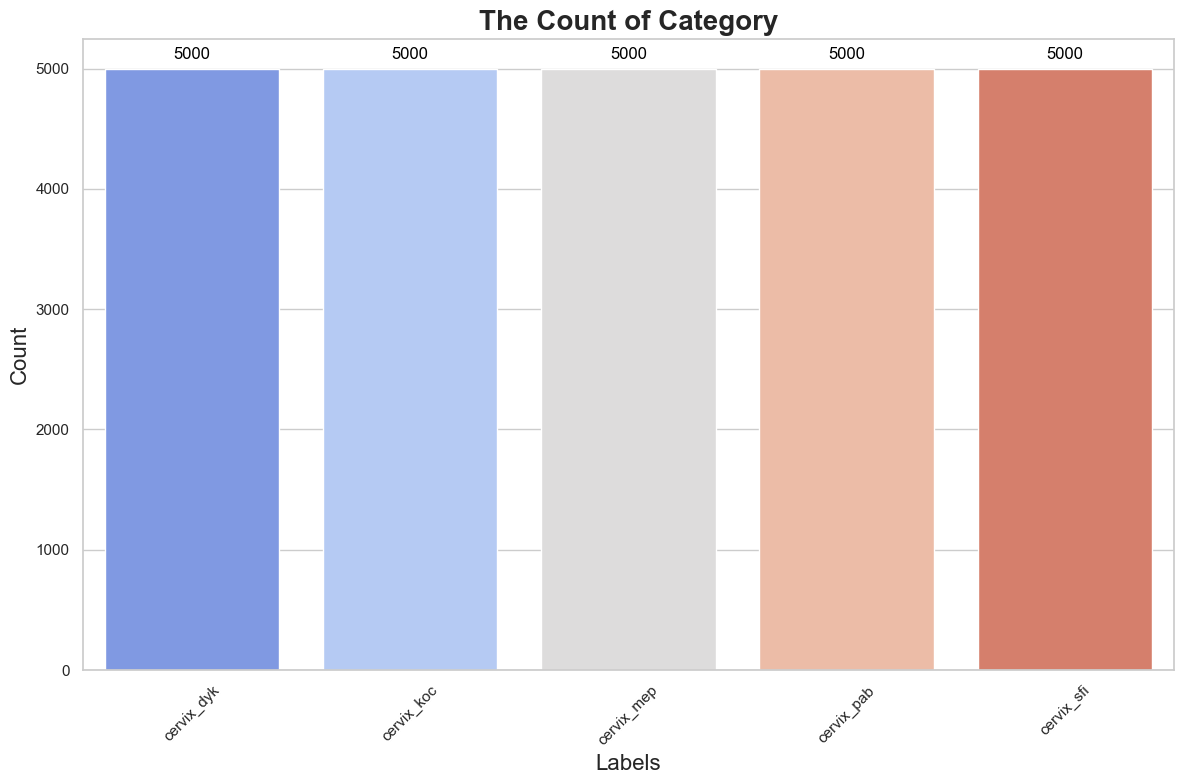

In [9]:
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", n_colors=len(counts))

plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x=counts.index, y=counts.values, palette=palette)

plt.title('The Count of Category', fontsize=20, fontweight='bold')
plt.xlabel('Labels', fontsize=16)
plt.ylabel('Count', fontsize=16)

for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=12, color='black', 
                      xytext=(0, 5), 
                      textcoords='offset points')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
strat=df['labels']
train_df ,dummy_df=train_test_split(df,test_size=0.3,random_state=42,stratify=strat)
strate=dummy_df['labels']
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=strate)

In [11]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(17500, 2)
(3750, 2)
(3750, 2)


In [12]:
batch_size = 32 
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


In [15]:
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model3 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),  
    Dropout(0.25),
    Dense(64, activation='relu'), 
    Dropout(0.25),
    Dense(5, activation='softmax')
])

optimizer = Adamax(learning_rate=0.002)
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model3.fit(
     train_gen,
     epochs=20,
     validation_data=valid_gen,
     shuffle=False,
     callbacks=[early_stopping, model_checkpoint],
     validation_steps=None
)

Epoch 1/20
269/547 [=============>................] - ETA: 1:56 - loss: 3.5302 - accuracy: 0.5922

KeyboardInterrupt: 

In [14]:
best_model = load_model('best_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_gen, verbose=2)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

118/118 - 46s - loss: 0.0173 - accuracy: 0.9957 - 46s/epoch - 388ms/step
Test Loss: 0.0173
Test Accuracy: 0.9957


In [15]:
test_loss, test_accuracy = model3.evaluate(test_gen)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

118/118 [==============================] - 13s 109ms/step - loss: 0.0173 - accuracy: 0.9957
Test Loss: 0.0173
Test Accuracy: 1.00


118/118 [==============================] - 15s 109ms/step


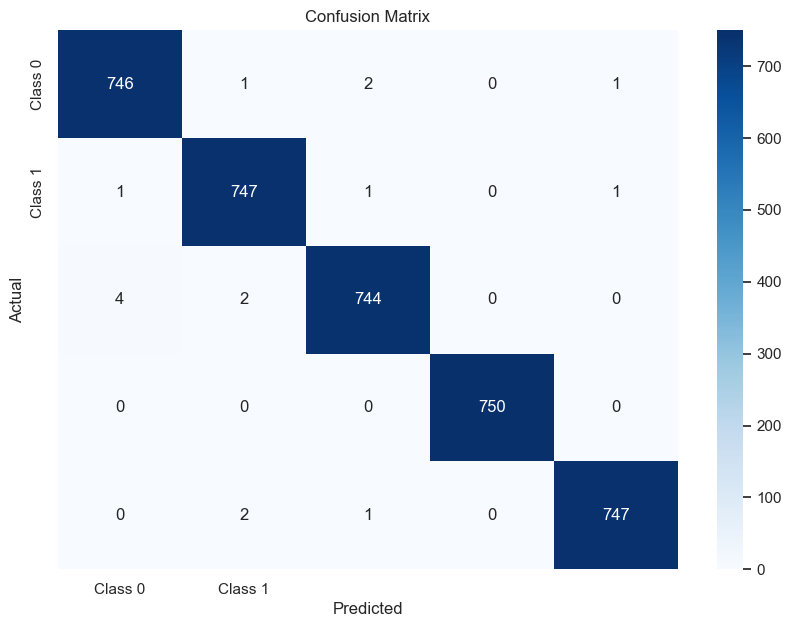

              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99       750
     Class 1       0.99      1.00      0.99       750
     Class 2       0.99      0.99      0.99       750
     Class 3       1.00      1.00      1.00       750
     Class 4       1.00      1.00      1.00       750

    accuracy                           1.00      3750
   macro avg       1.00      1.00      1.00      3750
weighted avg       1.00      1.00      1.00      3750



In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred_prob = best_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_true, y_pred_classes, target_names=["Class 0", "Class 1","Class 2","Class 3","Class 4"])
print(class_report)

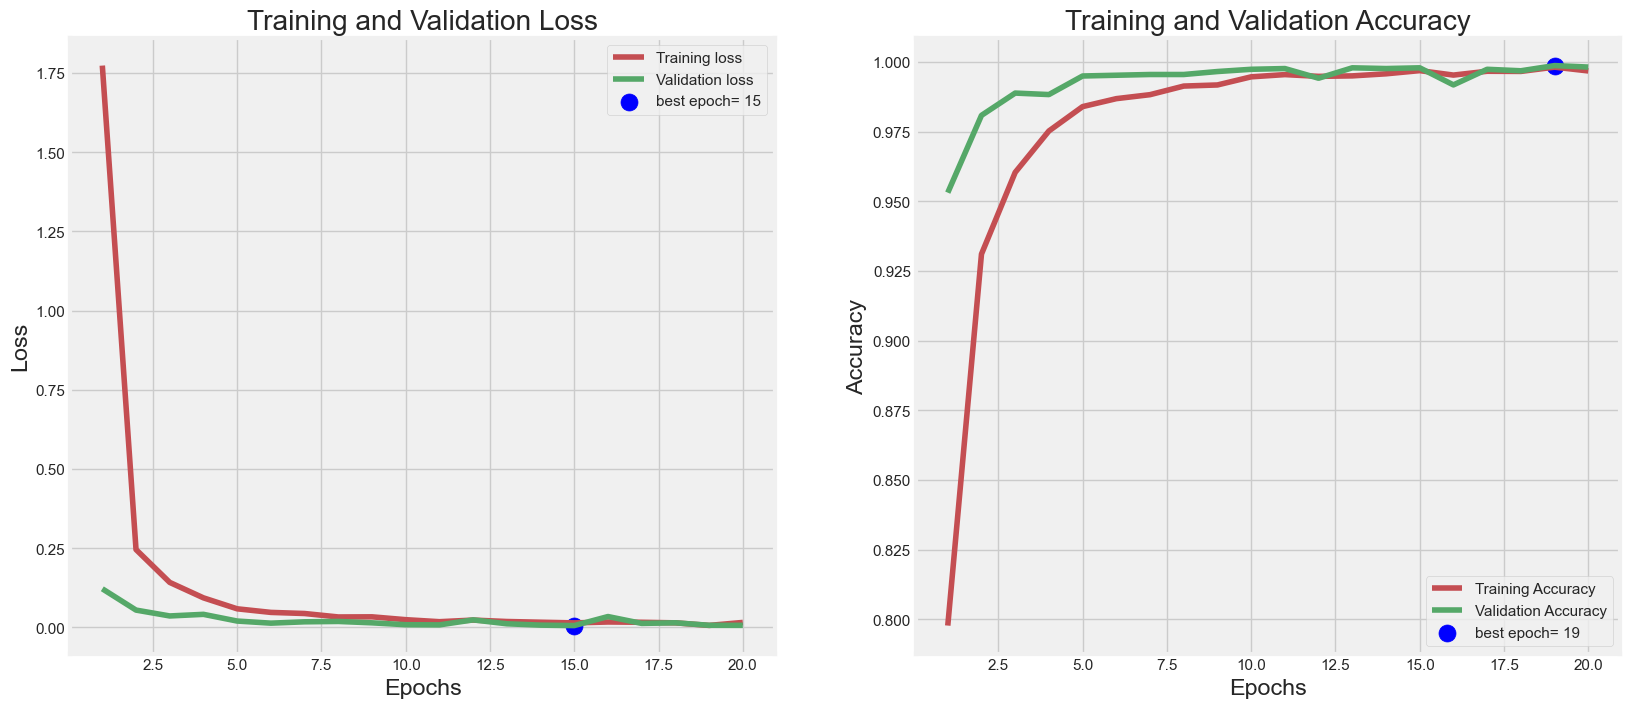

In [17]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [18]:
model3.save("Cervical Cancer.h5")

Total cervix_dyk images: 5000
Total cervix_koc images: 5000
Total cervix_mep images: 5000
Total cervix_pab images: 5000
Total cervix_sfi images: 5000
1/1 [==============================] - 0s 28ms/step


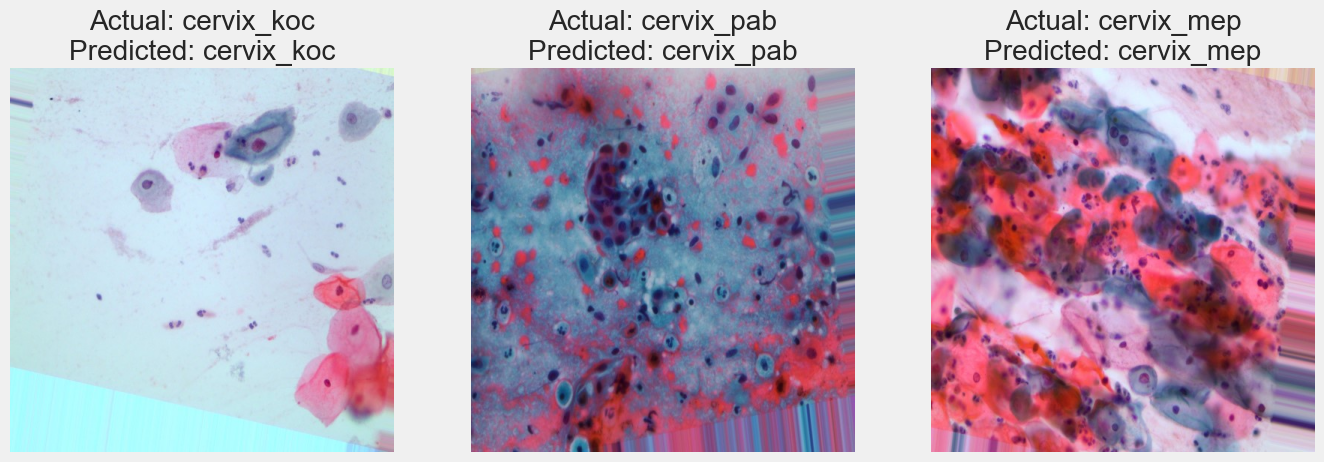

1/1 [==============================] - 0s 28ms/step


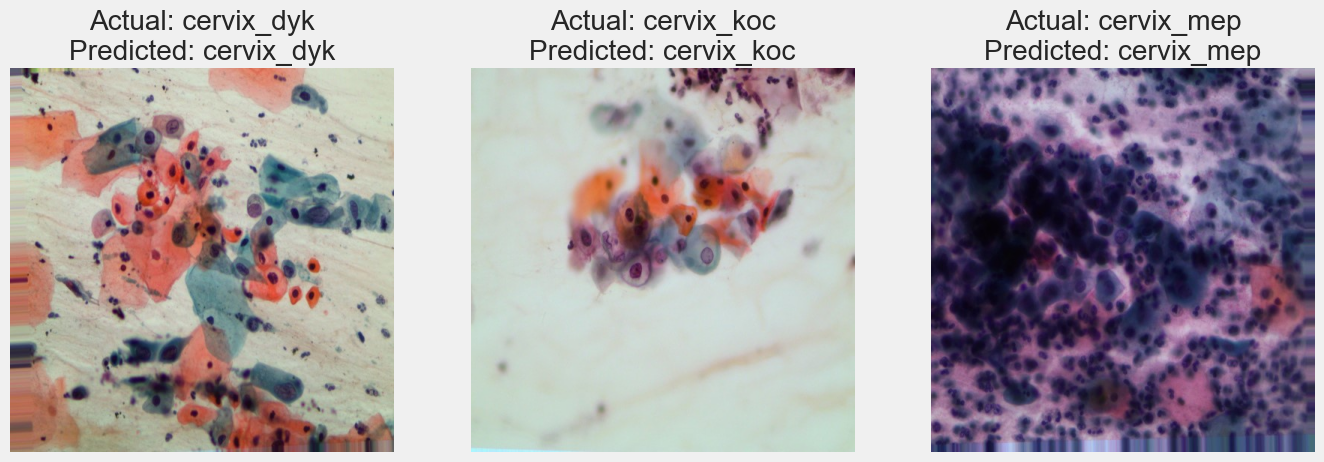

1/1 [==============================] - 0s 32ms/step


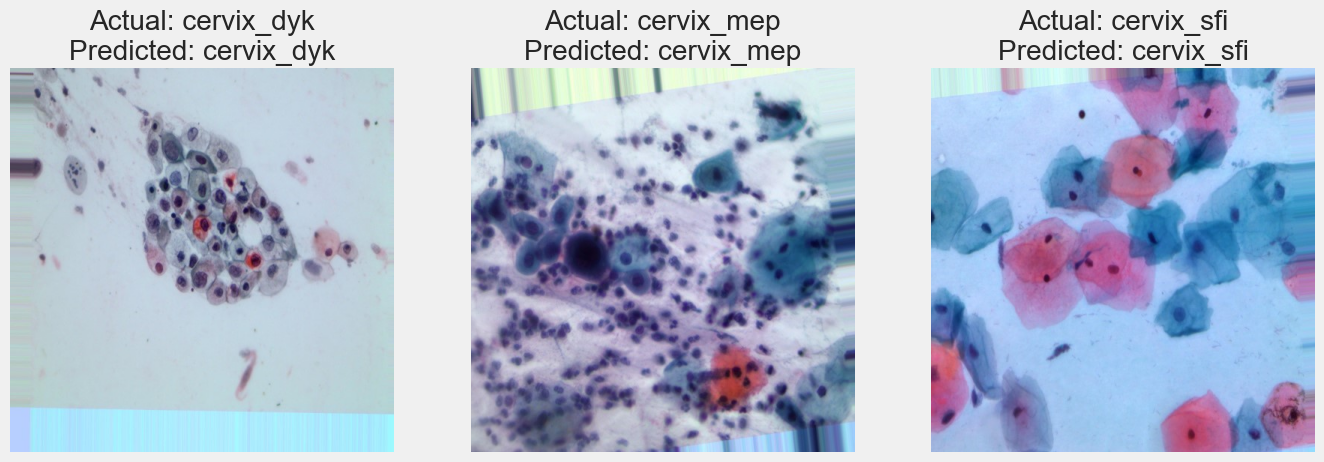

1/1 [==============================] - 0s 28ms/step


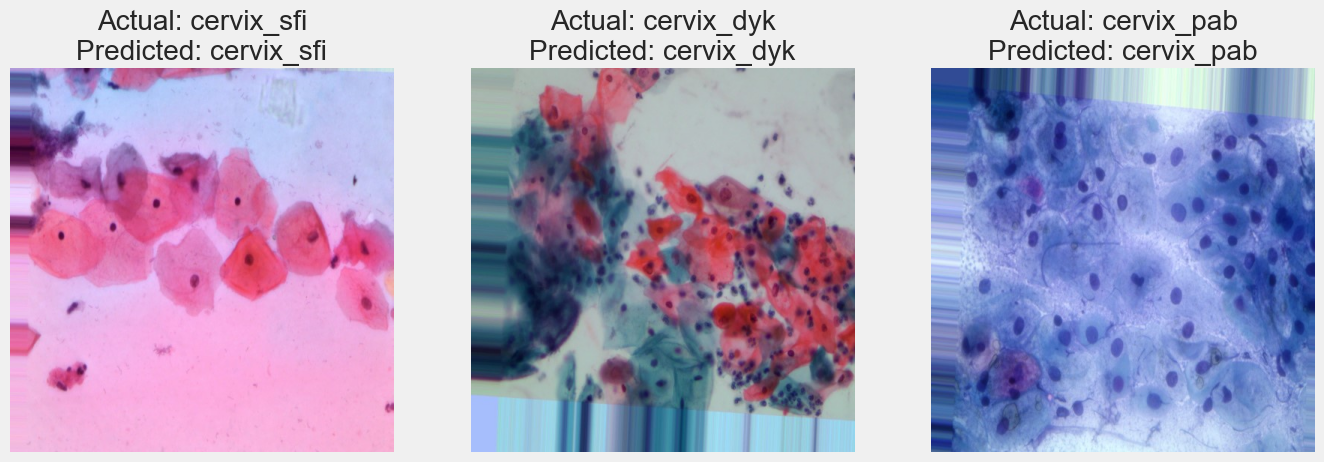

1/1 [==============================] - 0s 27ms/step


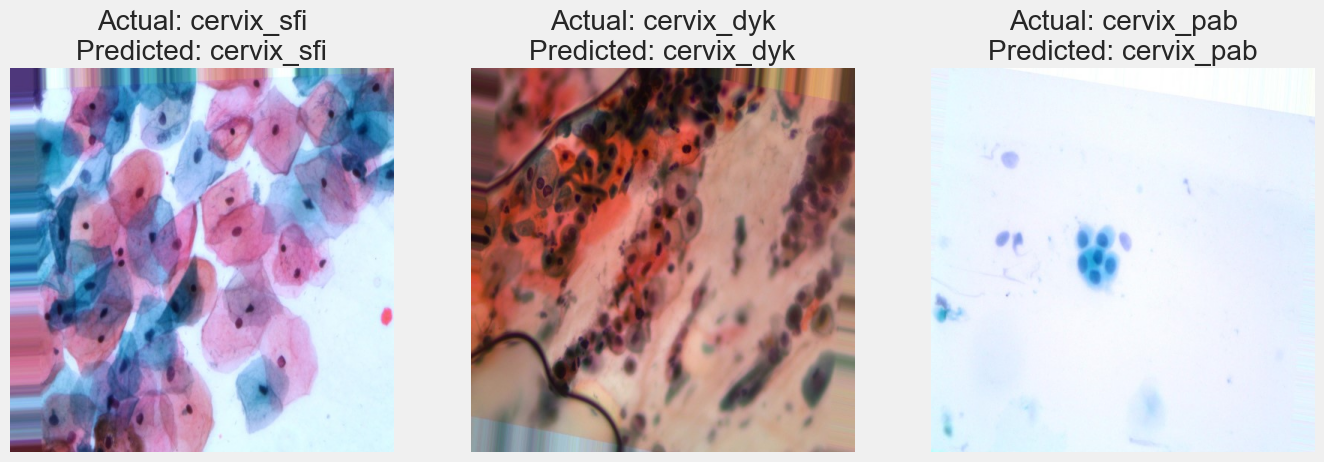

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

dataset_path = './Multi Cancer/Cervical Cancer'
cervix_categories = ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
num_classes = len(cervix_categories)

image_paths = []
actual_labels = []

for index, category in enumerate(cervix_categories):
    category_path = os.path.join(dataset_path, category)
    images_list = os.listdir(category_path)
    image_count = len(images_list)
    print(f"Total {category} images: {image_count}")

    image_paths.extend([os.path.join(category_path, img) for img in images_list])
    actual_labels.extend([index] * image_count)

def display_samples(image_paths, actual_labels, model, num_samples=3):
    selected_indices = np.random.choice(len(image_paths), num_samples, replace=False)
    plt.figure(figsize=(15, 5))
    
    for i, idx in enumerate(selected_indices):
        img_path = image_paths[idx]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img_resized = cv2.resize(img_rgb, (224, 224))
        img_array = np.expand_dims(img_resized, axis=0)
        
        prediction = model3.predict(img_array)
        predicted_label = np.argmax(prediction, axis=-1)[0]
        actual_label = actual_labels[idx]
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"Actual: {cervix_categories[actual_label]}\nPredicted: {cervix_categories[predicted_label]}")
        plt.axis('off')
    plt.show()

for category in cervix_categories:
    display_samples(image_paths, actual_labels, model3)